# Week 9: A Pandas Approach to TTRs in the Colonial South Asian Literature dataset


Topics:
- Renaming columns
- Merging data frames
- Defining functions
- Moving window average TTR
- Using `.groupby()` to get average TTRs for different categories

# Loading the CSAL Dataset

Let's begin by loading the CSAL dataset and having a look at what kinds of "metadata" it contains.

In [77]:
import pandas as pd

In [78]:
csal_meta_df = pd.read_csv('csal.csv')

In [79]:
csal_meta_df

,Text,Author,Title,Year,Original (if translated),Genre,Publisher Location,Publisher Name,Nationality of Author,Keywords,Origin
0,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,William Delafield Arnold,"Oakfield; Or, Fellowship in the East",1855,NaN,Fiction,Cambridge,"Metcalf and Company, Printers to the University",British,NaN,HathiTrust
1,F-W-Bain-Digit-of-the-Moon-A-Hindoo-Love-Story...,Francis William Bain,A Hindoo Love Story,1898,NaN,Fiction,London,Methuen & Co. Ltd.,British,"Translation from Sanskrti (""The Churning of th...",HathiTrust
2,S-B-Banerjea-Tales-of-Bengal-Fiction.txt,S.B. Banerjea,Tales of Bengal,1910,NaN,Fiction,"New York, Bombay, Calcutta","Longmans, Green, and Co.",South Asian,Introduction by Francis H. Skrine,Gutenberg
3,Edmund-Candler-The-Sepoy-1919-Nonfiction.txt,Edmund Candler,The Sepoy,1919,NaN,Fiction,London,John Murray,British,NaN,Gutenberg
4,Edmund-Candler-Abdication-1922-fiction.txt,Edmund Candler,Abdication,1922,NaN,Fiction,"London, Bombay",Constable & Co.,British,NaN,HathiTrust
...,...,...,...,...,...,...,...,...,...,...,...
105,Collected-Poems-of-Henry-Derozio-Downloadable.txt,Henry Louis Vivian Derozio,Collected Poems,1828,NaN,Poetry,Calcutta,Samuel Smith and Co.,South Asian,NaN,NaN
106,Peary-Chand-Mitter-A-Biographical-Sketch-of-Da...,Peary Chand Mitra,A Biographical Sketch of David Hare,1877,NaN,Nonfiction,Calcutta,W. Newman and Co.,South Asian,NaN,NaN
107,Peary-Chand-Mitter-The-Spoilt-Child-A-Tale-of-...,Peary Chand Mitra,The Spoilt Child (translation of Alaler Gharer...,1893,1857.0,Fiction,Calcutta,"Thacker, Spink and Co.",South Asian,Translated by G. Oswell,NaN
108,Flora-Annie-Steel-The-Flower-of-Forgiveness-18...,Flora Annie Steel,The Flower of Forgiveness,1894,NaN,Fiction,"London, New York",Macmillan and Co.,British,NaN,NaN


In [82]:
csal_meta_df.describe(include="all")

,Text,Author,Title,Year,Original (if translated),Genre,Publisher Location,Publisher Name,Nationality of Author,Keywords,Origin
count,110,110,110,110.000000,14.000000,110,84,81,110,50,101
unique,110,44,110,NaN,NaN,4,22,59,7,41,5
top,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,Rudyard Kipling,"Oakfield; Or, Fellowship in the East",NaN,NaN,Fiction,London,Macmillan and Co.,British,Juvenile Fiction,Gutenberg
freq,1,11,1,NaN,NaN,84,30,5,51,5,64
mean,NaN,NaN,NaN,1903.627273,1891.928571,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,19.213365,21.211261,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,1828.000000,1857.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,1894.000000,1874.250000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,1908.000000,1897.500000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,1917.000000,1910.750000,NaN,NaN,NaN,NaN,NaN,NaN


Our task today is to investigate whether the South Asian or "foreign" writers use a higher TTR in their works. So the most important column for us at this point is `Nationality of Author`. Let's have a closer look at what it contains.

In [83]:
csal_meta_df['Nationality of Author'].value_counts()

Nationality of Author
British                 51
South Asian             35
American                13
Canadian                 5
Irish                    3
South Asian; British     2
British, American        1
Name: count, dtype: int64

<Axes: ylabel='count'>

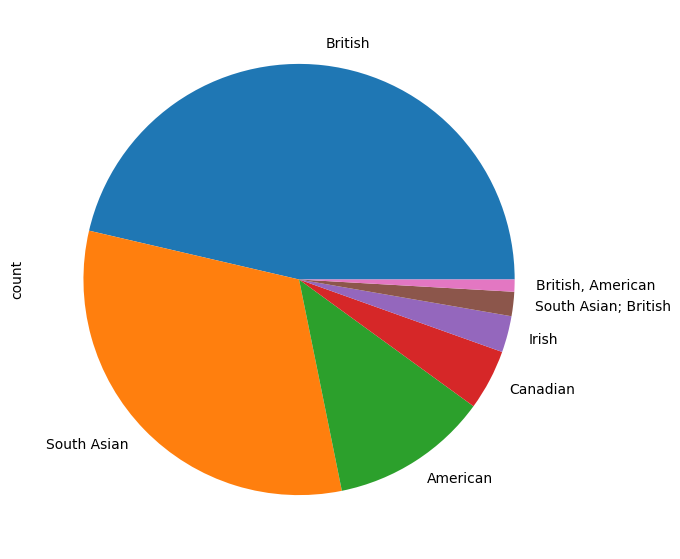

In [84]:
csal_meta_df['Nationality of Author'].value_counts().plot(kind="pie", figsize=(7, 7))

Let's also have a look at `Genre`, which might be interesting to us in a bit as well...

In [85]:
csal_meta_df['Genre'].value_counts()

Genre
Fiction       84
Nonfiction    14
Poetry        10
Drama          2
Name: count, dtype: int64

<Axes: ylabel='count'>

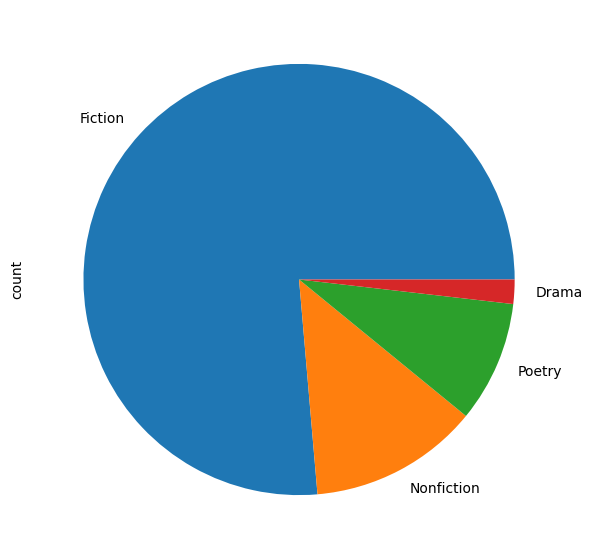

In [86]:
csal_meta_df['Genre'].value_counts().plot(kind="pie", figsize=(7, 7))

# Approaching TTR Task in Pandas

Okay, now let's take a step back and re-approach our TTR task with a Pandas mindset. 

When we took on this task in the first half of the semester, we just wanted to output our analysis to a CSV spreadsheet file and consider our task done.

Now that we have been introduced to Pandas, let's instead plan on gathering our results into DataFrames, with the aim of eventually putting new columns into the `csal_meta_df` DataFrame with TTR values for every text. We'll include both the standardized TTR and look at a new way of computing a TTR using a "moving window" which allows us to try out different sizes for numbers of tokens. Once we have that big DataFrame with those extra columns, we'll be able to do some fancy analysis!

We'll start by recycling our code from a few weeks ago, except this time, we'll load those CSV files we create back into Python as Pandas dataframes!


## Generating TTR CSV files... and Loading Them Back as Pandas DataFrames

Let's start by using some code directly recycled** from the Week 5 lecture. 

The code below iterates through all the files in the `csal` folder, which contains all the CSAL texts, and generates CSV files for their standardized values. There are 110 files in the CSAL dataset, some of them quite large, so this will take a second!

** There are some differences between this code and the code we used in Week 5: I removed the code to compute the overall TTR since that isn't very useful. I have grabbed the full file name with extension of each text file in the `Text` column, so that it matches what's in the `csal_meta_df` `Text` columns. You'll see why that's important in a second... The other difference is that this code now labels the TTR columns with more specific labels that will  come in handy later.

### BEFORE RUNNING THE BELOW CELL: It takes a while to run this code, since the CSAL dataset is pretty big, so I have placed the output files of the below cell in your JupyterHubs for demonstration purposes! IF YOU'RE FOLLOWING ALONG IN CLASS, LET'S AVOID CRASHING THE SERVER BY SKIPPING THE BELOW STEP.

In [87]:
import re
from pathlib import Path

folder_path = "csal/" # We're telling the code to look in the "csal/" subfolder, where the CSAL files all live.

# compute the sample size:
sample_size = 0

for file_path in sorted(Path(folder_path).glob('*.txt')):
    
    text = open(file_path, encoding='utf-8').read()
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    
    text_words = text.split()
    num_tokens = len(text_words)
    
    if sample_size == 0 or num_tokens < sample_size:
        sample_size = num_tokens

# Open the output file and write the headers
file = open("ttr-standardized.csv", mode="w", encoding="utf-8")

# Column labels are precise, identifying these as "Standardized" values
file.write('"Text","Standardized Types","Standardized Tokens","Standardized TTR"\n') 

for file_path in sorted(Path(folder_path).glob('*.txt')):
    text = open(file_path, encoding='utf-8').read()
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    
    text_words = text.split()
    text_words_standardized = text_words[:sample_size]
    tokens_standardized = len(text_words_standardized)

    unique_words_standardized = []
    
    for word in text_words_standardized:
        word = word.lower()
        if word not in unique_words_standardized:
            unique_words_standardized.append(word)
            
    types_standardized = len(unique_words_standardized)
    
    ttr_standardized = (types_standardized / tokens_standardized) * 100
    
    # path.name used rather than path.stem so that recoreded filenames match CSAL metadata
    file.write(f'"{file_path.name}",{types_standardized},{tokens_standardized},{ttr_standardized:.2f}\n') 

file.close()

Okay, that has left us with our familiar `ttr-standardized.csv` results file. 

Let's use our old friend `pd.read_csv()` to load the newly created CSV files as Pandas DataFrames!

Note: I ran the notebook at home and created a pre-computed file named `ttr-standardized-prebaked.cvs` so that if the above code got modified and didn't work or if the kernel got interrupted or something, I would still have the precomputed file w/ the full, uncorrupted data.

I'll use those now, for purposes of live, in-class demonstrations.  At your leisure, you can run the above code yourself and use the files you computed, after modifying which files are read in below.

In [ ]:
standardized_ttr_df = pd.read_csv("ttr-standardized-prebaked.csv")
#standardized_ttr_df = pd.read_csv("ttr-standardized.csv")

In [89]:
standardized_ttr_df

,Text,Standardized Types,Standardized Tokens,Standardized TTR
0,1897-Alice-Macdonald-Fleming-A-Pinchbeck-Godde...,1419,4051,35.03
1,Alice-Elizabeth-Dracott-Simla-Village-Tales-or...,1041,4051,25.70
2,Annie-Besant-The-Case-for-India-1917-Nonfictio...,1323,4051,32.66
3,Arthur-Conan-Doyle-The-Sign-of-the-Four-1890.txt,1302,4051,32.14
4,B-M-Croker-Dianna-Barrington-A-Romance-of-Cent...,1489,4051,36.76
...,...,...,...,...
105,Talbot-Mundy-The-Red-Flame-of-Erinpura-fiction...,1485,4051,36.66
106,Talbot-Mundy-The-Winds-of-the-World-1915-ficti...,1250,4051,30.86
107,Toru-Dutt-Ancient-Ballads-And-Legends-of-Hindu...,1504,4051,37.13
108,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,1170,4051,28.88



Please check out the the W09_moving_window.ipynb file to see how I computed the different values for moving windows. This will allow us to compare the standardized TTRs to the moving windows TTRs and do some simple statistics on them.

In [90]:
moving_windows_ttr_df = pd.read_csv("ttr-windows.csv")
moving_windows_ttr_df

,Text,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051
0,1897-Alice-Macdonald-Fleming-A-Pinchbeck-Godde...,69286,53.3,44.9,37.2,30.2
1,Alice-Elizabeth-Dracott-Simla-Village-Tales-or...,41675,45.0,36.4,28.9,22.5
2,Annie-Besant-The-Case-for-India-1917-Nonfictio...,18153,51.5,44.6,38.3,31.8
3,Arthur-Conan-Doyle-The-Sign-of-the-Four-1890.txt,43804,51.4,42.9,35.4,28.7
4,B-M-Croker-Dianna-Barrington-A-Romance-of-Cent...,138618,53.6,45.5,38.0,31.2
...,...,...,...,...,...,...
105,Talbot-Mundy-The-Red-Flame-of-Erinpura-fiction...,48937,53.9,45.9,38.7,32.1
106,Talbot-Mundy-The-Winds-of-the-World-1915-ficti...,52391,50.4,42.0,34.4,27.5
107,Toru-Dutt-Ancient-Ballads-And-Legends-of-Hindu...,22740,57.5,49.2,41.3,33.6
108,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,148965,51.6,43.5,36.2,29.6


# Merging DataFrames

Okay, let's say that instead of having our overall and standardized TTR values in separate DataFrames, we wanted to **merge** them into a single DataFrame that contains all the relevant data.

Well, we can do that quite easily with Pandas's `.merge()` method. We can only merge DataFrames that contain one column in common — otherwise, Pandas won't know exactly how to combine them. But thankfully our DataFrames do have one column in common: `Text`.

Below is the command we use to `.merge()` our two DataFrames, **"on"** the column they have in common. 

In [91]:
pd.merge(moving_windows_ttr_df, standardized_ttr_df, on="Text")

,Text,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized Types,Standardized Tokens,Standardized TTR
0,1897-Alice-Macdonald-Fleming-A-Pinchbeck-Godde...,69286,53.3,44.9,37.2,30.2,1419,4051,35.03
1,Alice-Elizabeth-Dracott-Simla-Village-Tales-or...,41675,45.0,36.4,28.9,22.5,1041,4051,25.70
2,Annie-Besant-The-Case-for-India-1917-Nonfictio...,18153,51.5,44.6,38.3,31.8,1323,4051,32.66
3,Arthur-Conan-Doyle-The-Sign-of-the-Four-1890.txt,43804,51.4,42.9,35.4,28.7,1302,4051,32.14
4,B-M-Croker-Dianna-Barrington-A-Romance-of-Cent...,138618,53.6,45.5,38.0,31.2,1489,4051,36.76
...,...,...,...,...,...,...,...,...,...
105,Talbot-Mundy-The-Red-Flame-of-Erinpura-fiction...,48937,53.9,45.9,38.7,32.1,1485,4051,36.66
106,Talbot-Mundy-The-Winds-of-the-World-1915-ficti...,52391,50.4,42.0,34.4,27.5,1250,4051,30.86
107,Toru-Dutt-Ancient-Ballads-And-Legends-of-Hindu...,22740,57.5,49.2,41.3,33.6,1504,4051,37.13
108,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,148965,51.6,43.5,36.2,29.6,1170,4051,28.88


But we probably don't want the types and tokens columns, so let's get rid of them.

In [92]:
# create a data frame with only the columns we want in our merged data frame
standardized_ttr_df = standardized_ttr_df[['Text', 'Standardized TTR']]

Now let's go ahead and stick that into a variable

In [93]:
ttr_df = pd.merge(moving_windows_ttr_df, standardized_ttr_df, on="Text")

In [94]:
ttr_df

,Text,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized TTR
0,1897-Alice-Macdonald-Fleming-A-Pinchbeck-Godde...,69286,53.3,44.9,37.2,30.2,35.03
1,Alice-Elizabeth-Dracott-Simla-Village-Tales-or...,41675,45.0,36.4,28.9,22.5,25.70
2,Annie-Besant-The-Case-for-India-1917-Nonfictio...,18153,51.5,44.6,38.3,31.8,32.66
3,Arthur-Conan-Doyle-The-Sign-of-the-Four-1890.txt,43804,51.4,42.9,35.4,28.7,32.14
4,B-M-Croker-Dianna-Barrington-A-Romance-of-Cent...,138618,53.6,45.5,38.0,31.2,36.76
...,...,...,...,...,...,...,...
105,Talbot-Mundy-The-Red-Flame-of-Erinpura-fiction...,48937,53.9,45.9,38.7,32.1,36.66
106,Talbot-Mundy-The-Winds-of-the-World-1915-ficti...,52391,50.4,42.0,34.4,27.5,30.86
107,Toru-Dutt-Ancient-Ballads-And-Legends-of-Hindu...,22740,57.5,49.2,41.3,33.6,37.13
108,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,148965,51.6,43.5,36.2,29.6,28.88


# Merging the TTR Data with the CSAL Metadata

It's worth remembering at this time that the CSAL Metadata (currently stored in `csal_meta_df`) also contains that same `Text` column — and so we can also create a mega-merged DataFrame that contains all the CSAL metadata and all the TTR analysis we've just done. This will allow us to analyze our TTRs by our various metadata categories, including author nationality.

In [95]:
csal_ttr_df = pd.merge(csal_meta_df, ttr_df, on="Text")

In [96]:
csal_ttr_df

,Text,Author,Title,Year,Original (if translated),Genre,Publisher Location,Publisher Name,Nationality of Author,Keywords,Origin,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized TTR
0,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,William Delafield Arnold,"Oakfield; Or, Fellowship in the East",1855,NaN,Fiction,Cambridge,"Metcalf and Company, Printers to the University",British,NaN,HathiTrust,148965,51.6,43.5,36.2,29.6,28.88
1,F-W-Bain-Digit-of-the-Moon-A-Hindoo-Love-Story...,Francis William Bain,A Hindoo Love Story,1898,NaN,Fiction,London,Methuen & Co. Ltd.,British,"Translation from Sanskrti (""The Churning of th...",HathiTrust,29953,47.7,39.9,32.3,25.7,31.52
2,S-B-Banerjea-Tales-of-Bengal-Fiction.txt,S.B. Banerjea,Tales of Bengal,1910,NaN,Fiction,"New York, Bombay, Calcutta","Longmans, Green, and Co.",South Asian,Introduction by Francis H. Skrine,Gutenberg,46332,55.0,47.3,40.3,33.4,41.15
3,Edmund-Candler-The-Sepoy-1919-Nonfiction.txt,Edmund Candler,The Sepoy,1919,NaN,Fiction,London,John Murray,British,NaN,Gutenberg,48275,51.7,44.3,37.6,31.3,33.33
4,Edmund-Candler-Abdication-1922-fiction.txt,Edmund Candler,Abdication,1922,NaN,Fiction,"London, Bombay",Constable & Co.,British,NaN,HathiTrust,82903,52.6,45.5,39.1,33.1,35.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Collected-Poems-of-Henry-Derozio-Downloadable.txt,Henry Louis Vivian Derozio,Collected Poems,1828,NaN,Poetry,Calcutta,Samuel Smith and Co.,South Asian,NaN,NaN,46855,55.0,46.5,38.5,31.0,29.15
106,Peary-Chand-Mitter-A-Biographical-Sketch-of-Da...,Peary Chand Mitra,A Biographical Sketch of David Hare,1877,NaN,Nonfiction,Calcutta,W. Newman and Co.,South Asian,NaN,NaN,52642,50.6,43.7,37.4,31.4,31.30
107,Peary-Chand-Mitter-The-Spoilt-Child-A-Tale-of-...,Peary Chand Mitra,The Spoilt Child (translation of Alaler Gharer...,1893,1857.0,Fiction,Calcutta,"Thacker, Spink and Co.",South Asian,Translated by G. Oswell,NaN,70205,52.3,44.2,37.1,30.6,32.16
108,Flora-Annie-Steel-The-Flower-of-Forgiveness-18...,Flora Annie Steel,The Flower of Forgiveness,1894,NaN,Fiction,"London, New York",Macmillan and Co.,British,NaN,NaN,83093,54.4,46.2,38.6,31.5,33.82


Let's learn a little more about this new mega-DataFrame we're created...

In [97]:
csal_ttr_df.describe(include="all")

,Text,Author,Title,Year,Original (if translated),Genre,Publisher Location,Publisher Name,Nationality of Author,Keywords,Origin,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized TTR
count,110,110,110,110.000000,14.000000,110,84,81,110,50,101,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
unique,110,44,110,NaN,NaN,4,22,59,7,41,5,NaN,NaN,NaN,NaN,NaN,NaN
top,W-D-Arnold-Oakfield-or-Fellowship-in-the-East-...,Rudyard Kipling,"Oakfield; Or, Fellowship in the East",NaN,NaN,Fiction,London,Macmillan and Co.,British,Juvenile Fiction,Gutenberg,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,11,1,NaN,NaN,84,30,5,51,5,64,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1903.627273,1891.928571,NaN,NaN,NaN,NaN,NaN,NaN,65174.854545,51.104545,43.064545,35.753636,29.075455,31.098364
std,NaN,NaN,NaN,19.213365,21.211261,NaN,NaN,NaN,NaN,NaN,NaN,42907.137253,3.373599,3.601747,3.662046,3.541087,4.229112
min,NaN,NaN,NaN,1828.000000,1857.000000,NaN,NaN,NaN,NaN,NaN,NaN,4051.000000,38.800000,30.400000,23.600000,18.400000,17.500000
25%,NaN,NaN,NaN,1894.000000,1874.250000,NaN,NaN,NaN,NaN,NaN,NaN,31034.250000,49.125000,40.825000,33.525000,27.100000,28.992500
50%,NaN,NaN,NaN,1908.000000,1897.500000,NaN,NaN,NaN,NaN,NaN,NaN,52516.500000,51.450000,43.600000,36.450000,29.750000,31.175000
75%,NaN,NaN,NaN,1917.000000,1910.750000,NaN,NaN,NaN,NaN,NaN,NaN,92339.500000,53.500000,45.475000,38.200000,31.375000,33.812500


This is one of those occasions when `include="all"` parameter on the `df.describe()` method gives us more info that we really want. Let's try again without, which will only give us the "greatest hits" columns...

In [98]:
csal_ttr_df.describe()

,Year,Original (if translated),Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized TTR
count,110.000000,14.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,1903.627273,1891.928571,65174.854545,51.104545,43.064545,35.753636,29.075455,31.098364
std,19.213365,21.211261,42907.137253,3.373599,3.601747,3.662046,3.541087,4.229112
min,1828.000000,1857.000000,4051.000000,38.800000,30.400000,23.600000,18.400000,17.500000
25%,1894.000000,1874.250000,31034.250000,49.125000,40.825000,33.525000,27.100000,28.992500
50%,1908.000000,1897.500000,52516.500000,51.450000,43.600000,36.450000,29.750000,31.175000
75%,1917.000000,1910.750000,92339.500000,53.500000,45.475000,38.200000,31.375000,33.812500
max,1941.000000,1916.000000,179506.000000,57.500000,49.400000,43.100000,37.200000,41.150000


# Sorting by Column

Before we jump into our actual task for this week, let's see how you would sort the full dataset by Standardized TTR, from lowest to highest; then from highest to lowest.

In [99]:
csal_ttr_df.sort_values(by='Standardized TTR', ascending=True)

,Text,Author,Title,Year,Original (if translated),Genre,Publisher Location,Publisher Name,Nationality of Author,Keywords,Origin,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized TTR
34,Georgene-Faulkner-The-White-Elephant-and-Other...,Georgene Faulkner,The White Elephant and Other Tales from Old India,1929,NaN,Fiction,New York,P.F. Vollard Company,American,Juvenile Fiction,Gutenberg,17775,38.8,30.4,23.6,18.4,17.50
100,Rabindranath-Tagore-The-Post-Office.txt,Rabindranath Tagore,The Post Office,1914,1912.0,Drama,London,Macmillan Company,South Asian,Translated from Bengali by Devabrata Mukherjee,Gutenberg,7674,42.4,33.2,25.6,19.4,19.38
51,Rudyard-Kipling-Just-So-Stories.txt,Rudyard Kipling,Just So Stories,1902,NaN,Fiction,NaN,NaN,British,Juvenile fiction,Gutenberg,30540,41.5,32.8,25.7,19.9,22.09
10,Bankim-Chandra-Chatterji-Krishnakantas-Will-19...,Bankim Chandra Chatterji,Krishnakanta's Will,1917,1878.0,Fiction,NaN,NaN,South Asian,Translation; Translated by Dakshina Charan Roy,HathiTrust,37776,45.4,37.2,29.9,23.5,22.24
64,Dhan-Gopal-Mukerji-Kari-the-Elephant-1922-Fict...,Dhan Gopal Mukerji,Kari the Elephant,1922,NaN,Fiction,New York,Dutton & Company,South Asian,Juvenile Fiction,Gutenberg,19911,46.6,38.0,30.5,23.9,22.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,Toru-Dutt-Ancient-Ballads-And-Legends-of-Hindu...,Toru Dutt,Ancient Ballads and Legends of Hindustan,1885,NaN,Poetry,London,"Kegan Paul, Trench & Co.",South Asian,Preface by Edmund W. Gosse,Gutenberg,22740,57.5,49.2,41.3,33.6,37.13
17,Maud-Diver-Captain-Desmond-V-C-Fiction.txt,Maud Diver,"Captain Desmond, V.C.",1917,NaN,Fiction,"London, Edinburgh",William Blackwood and Sons,British,NaN,Gutenberg,119562,54.8,46.6,38.7,31.4,37.52
32,S-M-Edwardes-By-Ways-of-Bombay-Fiction.txt,Stephen Meredyth Edwardes,By-Ways of Bombay,1912,NaN,Nonfiction,NaN,NaN,British,Ethnography; Literary Quality,Gutenberg,30912,55.7,49.2,43.1,37.2,37.74
14,B-M-Croker-Proper-Pride-1882-fiction.txt,Bithia Mary Croker,Proper Pride,1882,NaN,Fiction,London,Tinsley Brothers,Irish,NaN,HathiTrust,105895,54.3,46.2,38.7,31.8,38.26


In [100]:
csal_ttr_df.sort_values(by='Standardized TTR', ascending=False)

,Text,Author,Title,Year,Original (if translated),Genre,Publisher Location,Publisher Name,Nationality of Author,Keywords,Origin,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized TTR
2,S-B-Banerjea-Tales-of-Bengal-Fiction.txt,S.B. Banerjea,Tales of Bengal,1910,NaN,Fiction,"New York, Bombay, Calcutta","Longmans, Green, and Co.",South Asian,Introduction by Francis H. Skrine,Gutenberg,46332,55.0,47.3,40.3,33.4,41.15
14,B-M-Croker-Proper-Pride-1882-fiction.txt,Bithia Mary Croker,Proper Pride,1882,NaN,Fiction,London,Tinsley Brothers,Irish,NaN,HathiTrust,105895,54.3,46.2,38.7,31.8,38.26
32,S-M-Edwardes-By-Ways-of-Bombay-Fiction.txt,Stephen Meredyth Edwardes,By-Ways of Bombay,1912,NaN,Nonfiction,NaN,NaN,British,Ethnography; Literary Quality,Gutenberg,30912,55.7,49.2,43.1,37.2,37.74
17,Maud-Diver-Captain-Desmond-V-C-Fiction.txt,Maud Diver,"Captain Desmond, V.C.",1917,NaN,Fiction,"London, Edinburgh",William Blackwood and Sons,British,NaN,Gutenberg,119562,54.8,46.6,38.7,31.4,37.52
30,Toru-Dutt-Ancient-Ballads-And-Legends-of-Hindu...,Toru Dutt,Ancient Ballads and Legends of Hindustan,1885,NaN,Poetry,London,"Kegan Paul, Trench & Co.",South Asian,Preface by Edmund W. Gosse,Gutenberg,22740,57.5,49.2,41.3,33.6,37.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Dhan-Gopal-Mukerji-Kari-the-Elephant-1922-Fict...,Dhan Gopal Mukerji,Kari the Elephant,1922,NaN,Fiction,New York,Dutton & Company,South Asian,Juvenile Fiction,Gutenberg,19911,46.6,38.0,30.5,23.9,22.41
10,Bankim-Chandra-Chatterji-Krishnakantas-Will-19...,Bankim Chandra Chatterji,Krishnakanta's Will,1917,1878.0,Fiction,NaN,NaN,South Asian,Translation; Translated by Dakshina Charan Roy,HathiTrust,37776,45.4,37.2,29.9,23.5,22.24
51,Rudyard-Kipling-Just-So-Stories.txt,Rudyard Kipling,Just So Stories,1902,NaN,Fiction,NaN,NaN,British,Juvenile fiction,Gutenberg,30540,41.5,32.8,25.7,19.9,22.09
100,Rabindranath-Tagore-The-Post-Office.txt,Rabindranath Tagore,The Post Office,1914,1912.0,Drama,London,Macmillan Company,South Asian,Translated from Bengali by Devabrata Mukherjee,Gutenberg,7674,42.4,33.2,25.6,19.4,19.38


# Using GroupBy and Mean to Get Our TTR-by-Nationality Data

Now that we have this mega-DataFrame — it contains all the CSAL metadata, and all our precious TTR data — we can pursue our original research question: do texts written by authors from the subcontinent have higher or lower TTRs than texts written by authors identified as foreign?

**What data do we actually need to see, in what format, to pursue that research question?**

Let's start by using our old friend `df.groupby()` and group this DataFrame by the `Nationality of Author` column.

In [101]:
csal_by_nationality_df = csal_ttr_df.groupby('Nationality of Author')
csal_by_nationality_df

DataFrames produced by GroupBy can't be visualized in the standard way that normal DataFrames are. We need to call methods on them to see what's inside. Remember what we're looking for: the **mean standardized TTR for each category of author nationality**. If we just call on old reliable `df.describe()`, we can see that this data is already the `csal_by_nationality_df` DataFrame we just produced. Do you see where it is in the below output?

In [102]:
csal_by_nationality_df.describe()

Year                                                   \
                      count         mean        std     min      25%     50%   
Nationality of Author                                                          
American               13.0  1918.923077  10.820209  1900.0  1914.00  1916.0   
British                51.0  1899.705882  15.386090  1855.0  1893.50  1900.0   
British, American       1.0  1892.000000        NaN  1892.0  1892.00  1892.0   
Canadian                5.0  1899.600000   7.021396  1893.0  1894.00  1898.0   
Irish                   3.0  1893.666667  15.307950  1882.0  1885.00  1888.0   
South Asian            35.0  1905.257143  25.186765  1828.0  1898.50  1916.0   
South Asian; British    2.0  1906.500000  17.677670  1894.0  1900.25  1906.5   

                                       Original (if translated)               \
                           75%     max                    count         mean   
Nationality of Author                                                          
American               1927.00  1937.0                      0.0          NaN   
British                1911.00  1924.0                      0.0          NaN   
British, American      1892.00  1892.0                      0.0          NaN   
Canadian               1903.00  1910.0                      0.0          NaN   
Irish                  1899.50  1911.0                      0.0          NaN   
South Asian            1918.50  1941.0                     14.0  1891.928571   
South Asian; British   1912.75  1919.0                      0.0          NaN   

                       ... TTR 4051       Standardized TTR             \
                       ...      75%   max            count       mean   
Nationality of Author  ...                                              
American               ...   30.400  35.3             13.0  31.086923   
British                ...   31.950  37.2             51.0  31.393529   
British, American      ...   30.100  30.1              1.0  28.980000   
Canadian               ...   31.600  31.6              5.0  30.242000   
Irish                  ...   31.500  31.8              3.0  36.846667   
South Asian            ...   31.000  33.6             35.0  30.200857   
South Asian; British   ...   29.675  30.3              2.0  33.930000   

                                                                      
                            std    min     25%    50%     75%    max  
Nationality of Author                                                 
American               5.032344  17.50  29.230  30.86  33.350  36.93  
British                3.945178  22.09  28.895  32.21  34.105  37.74  
British, American           NaN  28.98  28.980  28.98  28.980  28.98  
Canadian               1.848883  27.62  29.870  29.99  31.050  32.68  
Irish                  1.372054  35.52  36.140  36.76  37.510  38.26  
South Asian            4.517414  19.38  28.610  30.59  32.840  41.15  
South Asian; British   0.395980  33.65  33.790  33.93  34.070  34.21  

[7 rows x 64 columns]

Here's how we grab only the information we want from `csal_by_nationality_df` — subsetting to the `Standardized TTR` column (using a method we've been using for a few weeks now — passing a `['list containing a single string']` into the `dataframe[ ]` structure) and then calling the Pandas `.mean()` function on that column.

What we get from this is just a plain old Pandas DataFrame (not a GroupBy object)

In [103]:
csal_by_nationality_df[['TTR 4051', 'Standardized TTR']].mean()

,TTR 4051,Standardized TTR
Nationality of Author,,
American,28.684615,31.086923
British,29.125490,31.393529
"British, American",30.100000,28.980000
Canadian,30.020000,30.242000
Irish,31.400000,36.846667
South Asian,28.785714,30.200857
South Asian; British,29.050000,33.930000


In [104]:
type(csal_by_nationality_df[['Standardized TTR']].mean())

pandas.core.frame.DataFrame

Now let's stick that into a variable... and let's make a plot of the data we've uncovered... and then interpret the results together!

In [105]:
mean_ttr_by_nationality_df = csal_by_nationality_df[['Standardized TTR', 'TTR 4051']].mean()
mean_ttr_by_nationality_df = mean_ttr_by_nationality_df.rename(columns={'TTR 4051' : 'Moving Average TTR'})

<Axes: title={'center': 'Standardized TTRs Averaged Across Nationality of Author'}, xlabel='Nationality of Author'>

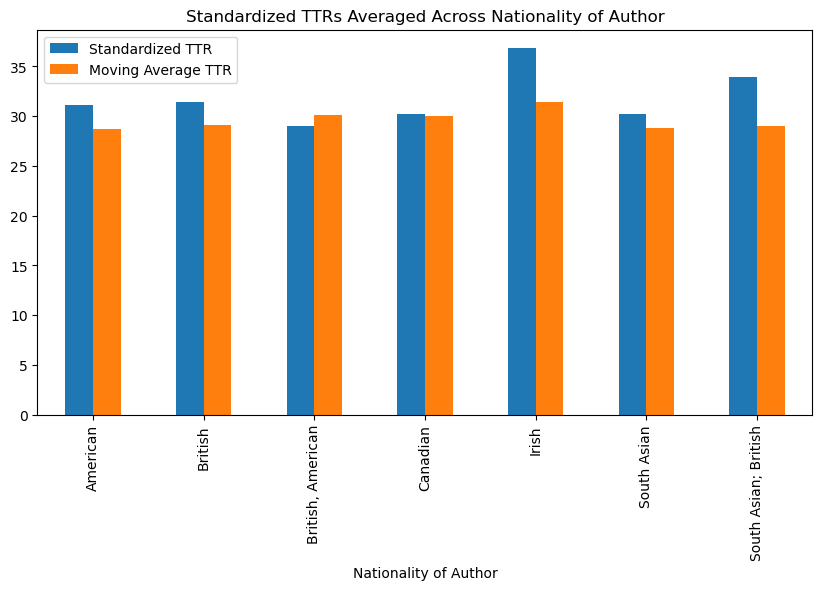

In [106]:
mean_ttr_by_nationality_df.plot(kind='bar', figsize=(10,5), title='Standardized TTRs Averaged Across Nationality of Author')

Let's now look at similar plots for TTR data sorted according to different metadata categories, using the same methods employed above. Does this give you any further insight into the results above?

In [107]:
csal_ttr_by_year_df = csal_ttr_df.groupby('Year')
mean_ttr_by_year_df = csal_ttr_by_year_df[['Standardized TTR', 'TTR 4051']].mean()
mean_ttr_by_year_df

,Standardized TTR,TTR 4051
Year,,
1828,29.150000,31.000000
1829,34.440000,31.000000
1855,28.880000,29.600000
1859,30.140000,28.900000
1860,33.670000,30.400000
1870,33.600000,21.400000
1873,29.250000,27.400000
1877,31.300000,31.400000
1879,25.480000,23.700000


<Axes: title={'center': 'Standardized TTRs Averaged Across Year of Publication'}, xlabel='Year'>

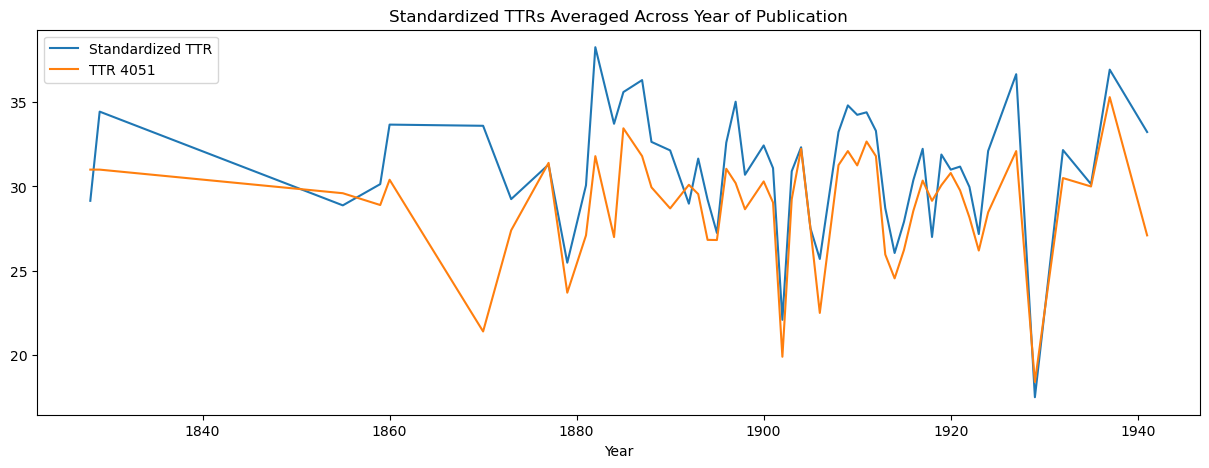

In [108]:
mean_ttr_by_year_df.plot(figsize=(15,5), title='Standardized TTRs Averaged Across Year of Publication')

Wait! Something looks strange there.  Why are the TTRs so different for 1870?

In [109]:
csal_ttr_df[csal_ttr_df['Year'] == 1870]

,Text,Author,Title,Year,Original (if translated),Genre,Publisher Location,Publisher Name,Nationality of Author,Keywords,Origin,Total Tokens,TTR 500,TTR 1000,TTR 2000,TTR 4051,Standardized TTR
37,M-Frere-Old-Deccan-Days-or-Hindoo-Fariy-Legend...,Mary Frere,"Old Deccan Days, Or Hindu Fairy Legends",1870,NaN,Fiction,Philadelphia,Lippincott's Press,British,Folklore,Gutenberg,104670,44.9,35.8,28.0,21.4,33.6


In [110]:
mean_ttr_by_genre_df = csal_ttr_df.groupby('Genre')[['Standardized TTR','TTR 4051']].mean()
mean_ttr_by_genre_df

,Standardized TTR,TTR 4051
Genre,,
Drama,24.760000,24.15
Fiction,30.817976,28.55
Nonfiction,33.311429,32.15
Poetry,31.623000,30.17


<Axes: title={'center': 'Standardized TTRs Averaged Across Genre of Text'}, xlabel='Genre'>

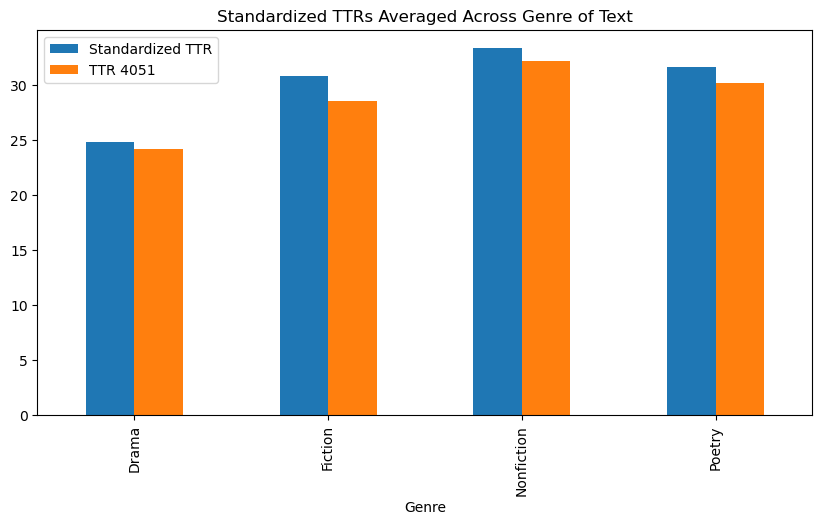

In [111]:
mean_ttr_by_genre_df.plot(kind='bar', figsize=(10,5), title='Standardized TTRs Averaged Across Genre of Text')

Let's use the techniques we learned last time to produce our gender signal-by-year plots to see exactly how many works in each Genre appear for each of the author nationalities.

In [112]:
csal_ttr_df.groupby(['Genre', 'Nationality of Author']).size()

Genre       Nationality of Author
Drama       South Asian               2
Fiction     American                 11
            British                  43
            British, American         1
            Canadian                  5
            Irish                     3
            South Asian              20
            South Asian; British      1
Nonfiction  American                  2
            British                   7
            South Asian               5
Poetry      British                   1
            South Asian               8
            South Asian; British      1
dtype: int64

In [113]:
csal_ttr_df.groupby(['Genre', 'Nationality of Author']).size().unstack()

Nationality of Author,American,British,"British, American",Canadian,Irish,South Asian,South Asian; British
Genre,,,,,,,
Drama,NaN,NaN,NaN,NaN,NaN,2.0,NaN
Fiction,11.0,43.0,1.0,5.0,3.0,20.0,1.0
Nonfiction,2.0,7.0,NaN,NaN,NaN,5.0,NaN
Poetry,NaN,1.0,NaN,NaN,NaN,8.0,1.0


In [114]:
csal_genre_by_nationality_df = csal_ttr_df.groupby(['Genre', 'Nationality of Author']).size().unstack(fill_value=0)
csal_genre_by_nationality_df

Nationality of Author,American,British,"British, American",Canadian,Irish,South Asian,South Asian; British
Genre,,,,,,,
Drama,0,0,0,0,0,2,0
Fiction,11,43,1,5,3,20,1
Nonfiction,2,7,0,0,0,5,0
Poetry,0,1,0,0,0,8,1


In [115]:
csal_genre_by_nationality_df = csal_ttr_df.groupby(['Genre', 'Nationality of Author'])[['Standardized TTR']].mean().unstack(fill_value=0)
csal_genre_by_nationality_df


Standardized TTR                                        \
Nationality of Author         American    British British, American Canadian   
Genre                                                                          
Drama                         0.000000   0.000000              0.00    0.000   
Fiction                      30.742727  30.740000             28.98   30.242   
Nonfiction                   32.980000  34.705714              0.00    0.000   
Poetry                        0.000000  36.310000              0.00    0.000   

                                                                   
Nationality of Author      Irish South Asian South Asian; British  
Genre                                                              
Drama                   0.000000    24.76000                 0.00  
Fiction                36.846667    30.18900                34.21  
Nonfiction              0.000000    31.49200                 0.00  
Poetry                  0.000000    30.78375                33.65

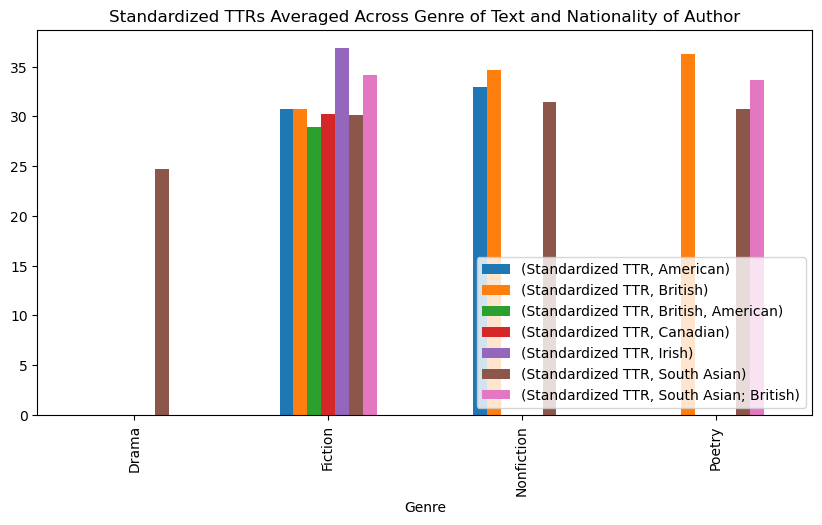

In [116]:
csal_genre_by_nationality_df.plot(kind='bar', figsize=(10,5), title='Standardized TTRs Averaged Across Genre of Text and Nationality of Author').legend(loc="lower right")

Note that things are lumped by rows: drama, fiction, etc.  What if we'd wanted things to be lumped by nationality?  We could create a new dataframe `csal_ttr_df.groupby(['Nationality of Author','Genre', ]).size().unstack(fill_value=0)` by exchanging the order of `Nationality of Author` and `Genre`

In [117]:
csal_ttr_df.groupby(['Nationality of Author','Genre', ])[['Standardized TTR']].mean().unstack(fill_value=0)

Standardized TTR                                
Genre                            Drama    Fiction Nonfiction    Poetry
Nationality of Author                                                 
American                          0.00  30.742727  32.980000   0.00000
British                           0.00  30.740000  34.705714  36.31000
British, American                 0.00  28.980000   0.000000   0.00000
Canadian                          0.00  30.242000   0.000000   0.00000
Irish                             0.00  36.846667   0.000000   0.00000
South Asian                      24.76  30.189000  31.492000  30.78375
South Asian; British              0.00  34.210000   0.000000  33.65000

Or we can use pandas' transpose command `csal_genre_by_nationality_df.T`

In [118]:
csal_genre_by_nationality_df.T

Genre                                   Drama    Fiction  Nonfiction    Poetry
                 Nationality of Author                                        
Standardized TTR American                0.00  30.742727   32.980000   0.00000
                 British                 0.00  30.740000   34.705714  36.31000
                 British, American       0.00  28.980000    0.000000   0.00000
                 Canadian                0.00  30.242000    0.000000   0.00000
                 Irish                   0.00  36.846667    0.000000   0.00000
                 South Asian            24.76  30.189000   31.492000  30.78375
                 South Asian; British    0.00  34.210000    0.000000  33.65000

And we can plot if we want!

[Text(0, 0, 'American'),
 Text(1, 0, 'Britsh'),
 Text(2, 0, 'British, American'),
 Text(3, 0, 'Canadian'),
 Text(4, 0, 'Irish'),
 Text(5, 0, 'South Asian'),
 Text(6, 0, 'South Asian; British')]

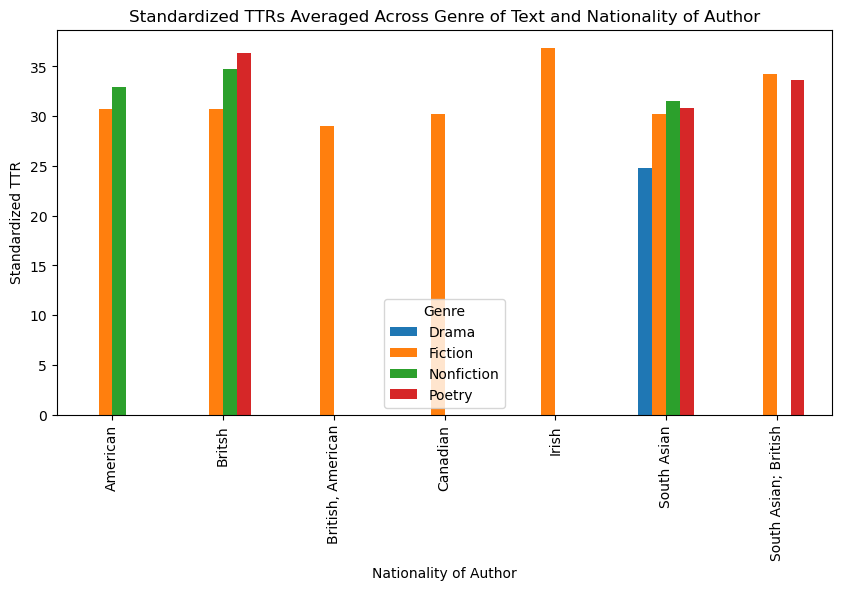

In [119]:
ax = csal_genre_by_nationality_df.T.plot(kind='bar', figsize=(10,5), title='Standardized TTRs Averaged Across Genre of Text and Nationality of Author', xlabel='Nationality of Author', ylabel='Standardized TTR')
ax.set_xticklabels(['American', 'Britsh', 'British, American', 'Canadian', 'Irish', 'South Asian', 'South Asian; British'])


Let's close today's class by 

- imagining how we could improve our approach to our original research question
- thinking of what other research questions we could ask of the CSAL dataset — with the TTR data we've added, or perhaps with some other metadata category or textual metric?